In [2]:
from minigrid.wrappers import ImgObsWrapper
import gymnasium as gym
from minigrid.core.grid import Grid
import torch
import matplotlib.pyplot as plt
import numpy as np
from stable_baselines3 import PPO
from minigrid.core.constants import COLOR_TO_IDX, OBJECT_TO_IDX
from PIL import Image



pygame 2.5.2 (SDL 2.28.2, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
env = gym.make("MiniGrid-FourRooms-v0", render_mode="rgb_array", agent_view_size=5)
env = ImgObsWrapper(env)

In [4]:
a,_ = env.reset()

In [5]:
def mask_output(obs):
    
    masked_logits = obs
    masked_logits[..., 0] %= 11
    masked_logits[..., 1] %= 6
    masked_logits[..., 2] %= 3

    return masked_logits



In [6]:
d, e = Grid.decode(mask_output(torch.randint(0, 10, (7, 7, 3)).numpy()))

In [13]:
        # Render the whole grid
img = d.render(
    16,
    agent_pos=(7 // 2, 7 - 1),
    agent_dir=3,
    # highlight_mask=False,
)

In [7]:
def decode_img(repr):
    d, e = Grid.decode(repr)
    return d.render(
        16,
        agent_pos=(5 // 2, 5 - 1),
        agent_dir=3,
        # highlight_mask=False,
    )

def decode_full_img(repr, agent_pos, agent_dir):
    d, e = Grid.decode(repr)
    return d.render(
        16,
        agent_pos=agent_pos,
        agent_dir=agent_dir,
        # highlight_mask=False,
    )

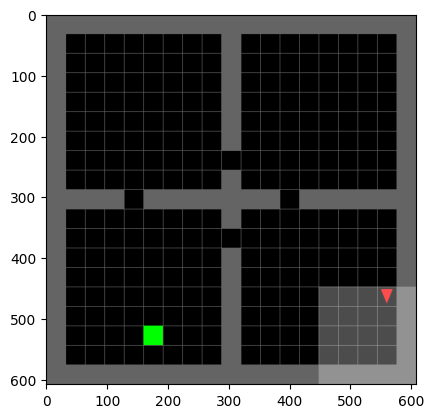

In [56]:
a,_ = env.reset()
plt.imshow(np.rot90(img, 0))

In [54]:
a[4:].shape

(1, 5, 3)

In [60]:
a[3, 4] = np.array([255, 255, 255])

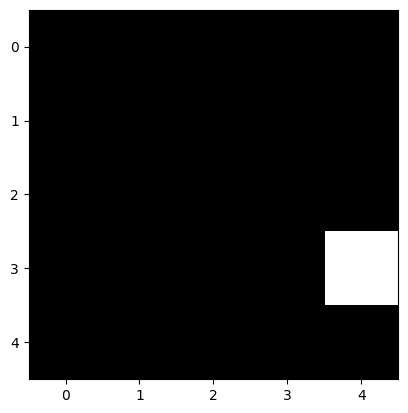

In [61]:
plt.imshow(a)

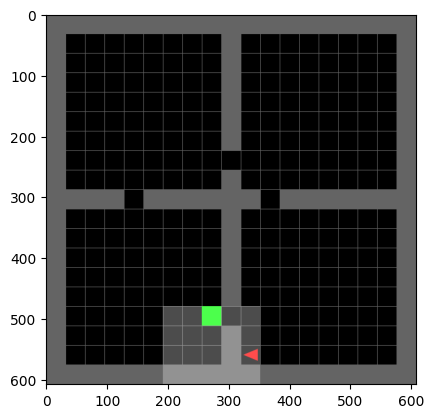

In [50]:
plt.imshow(env.render())

In [8]:
def get_top(agent_dir, agent_pos, short_side, long_side):
    x, y = agent_pos
    if agent_dir == 0:
        top = (x, max(y - short_side, 0))
    elif agent_dir == 1:
        top = (max(x - short_side, 0), y)
    elif agent_dir == 2:
        top = (max(x - long_side, 0), max(y - short_side, 0))
    elif agent_dir == 3:
        top = (max(x - short_side, 0), max(y - long_side, 0))
    
    return top

def update_full_view(env, view):
    agent_dir = env.agent_dir
    agent_pos = env.agent_pos

    x, y = agent_pos

    view_size = view.shape[0]

    short_side = view_size // 2
    long_side = view_size - 1

    y_top, x_top = get_top(agent_dir, agent_pos, short_side, long_side)

    end_x = env.size - x_top
    end_y = env.size - y_top


    if agent_dir == 0:
        start_y = short_side - y if y - short_side < 0 else 0
        start_x = 4 - x if x - long_side < 0 else 0
    elif agent_dir == 1:
        start_y = 0
        start_x = short_side - x if x - short_side < 0 else 0
    elif agent_dir == short_side:
        start_y = short_side - y if y - short_side < 0 else 0
        start_x = 0
    elif agent_dir == 3:
        start_y = long_side - y if y - long_side < 0 else 0
        start_x = short_side - x if x - short_side < 0 else 0

    cropped_view = view[start_y:end_y, start_x:end_x]

    full_view = env.grid.encode()

    width, height, _ = cropped_view.shape

    full_view[y_top:y_top+width, x_top:x_top+height] = cropped_view

    return full_view

def full_obs(env):
    full_grid = env.grid.encode()
    full_grid[env.agent_pos[0]][env.agent_pos[1]] = np.array(
        [OBJECT_TO_IDX["agent"], COLOR_TO_IDX["red"], env.agent_dir]
    )

    return full_grid[None, ...]

In [127]:
img = np.rot90(img, np.abs(env.agent_dir - 3))

/local/home/argesp/miniconda3/envs/minigrid_env/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_dir to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_dir` for environment variables or `env.get_wrapper_attr('agent_dir')` that will search the reminding wrappers.
  logger.warn(


In [9]:
model = PPO.load("/local/home/argesp/interface-minigrid/rl_model_600000_steps")
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [15]:
images = []
obs = model.env.reset()
img = model.env.render(mode="rgb_array")

mods_imgs = []
aligned_imgs = []
for i in range(400):
    action, _ = model.predict(obs)
    obs, _, _ ,_ = model.env.step(action)

    mod_img = mask_output(torch.randint(0, 10, (5, 5, 3)).numpy())

    mods_imgs.append(mod_img)

    aligned_img = np.rot90(mod_img, (4 - np.abs(env.agent_dir - 3)) % 4)

    aligned_imgs.append(aligned_img)

    full_view = update_full_view(env, aligned_img)

    images.append(Image.fromarray(decode_full_img(full_view, env.agent_pos, env.agent_dir)).convert('RGBA', dither=None, palette='WEB'))

    

/local/home/argesp/miniconda3/envs/minigrid_env/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_dir to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_dir` for environment variables or `env.get_wrapper_attr('agent_dir')` that will search the reminding wrappers.
  logger.warn(
/local/home/argesp/miniconda3/envs/minigrid_env/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.agent_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.agent_pos` for environment variables or `env.get_wrapper_attr('agent_pos')` that will search the reminding wrappers.
  logger.warn(
/local/home/argesp/miniconda3/envs/minigrid_env/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this

In [133]:
images[0].save(f"test.gif", format="GIF", append_images=images[1:], save_all=True, duration=len(images) // 4, loop=0)

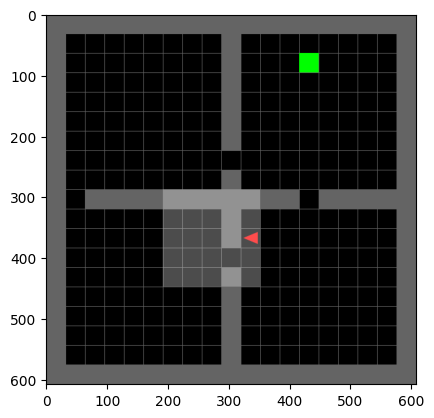

In [25]:
plt.imshow(env.render())

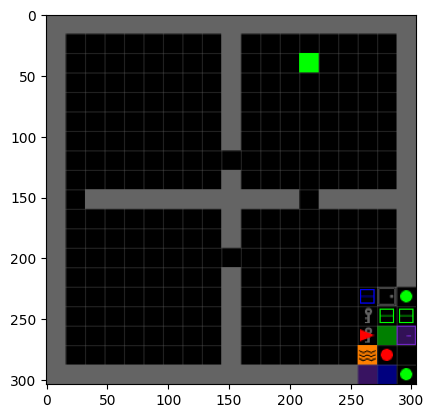

In [27]:
plt.imshow(images[-15])

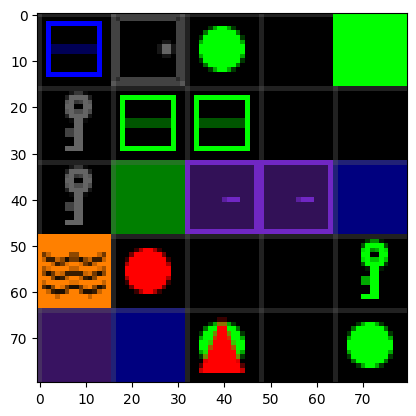

In [20]:
plt.imshow(decode_img(aligned_imgs[-15]))

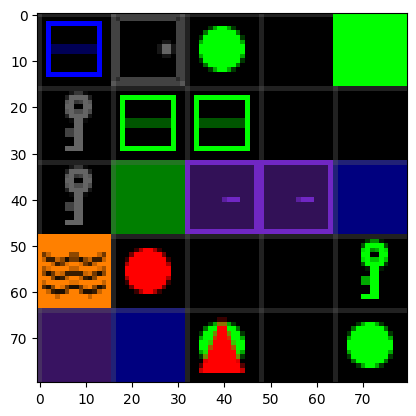

In [29]:
plt.imshow(decode_img(np.rot90(mods_imgs[-15], np.abs(0 - 3))))

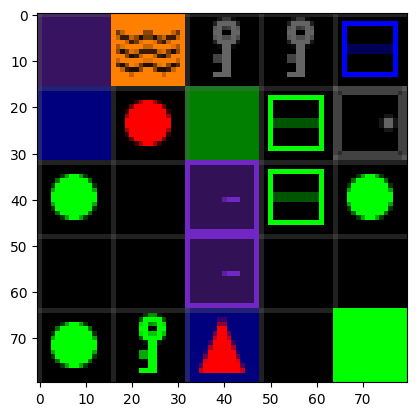

In [26]:
plt.imshow(decode_img(mods_imgs[-15]))

In [ ]:
0 -> 1
1 -> 2
2 -> 3

0 -> 3
1 -> 2
2 -> 1

